In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import plotly.express as px
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
with open('config/EDA.json') as fh:
    configs = json.load(fh)
    EDA_VIZ_PATH, TB_US_PATH = configs['EDA_VIZ_PATH'], configs['TB_US_PATH']

In [8]:
tb_use  = pd.read_csv(TB_US_PATH)
tb_use.head()

,Year,Locationabbr,Locationdesc,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,...,Confidence_limit_High,Data_value_unit,Data_value_type,Data_Value_Footnote,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
0,2019,KS,Kansas,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,25-34,Age Group,52,4.31,...,5.60,%,Crude Prevalence,NaN,20,AGE02,CAT3,USENOW3,RESP079,"(38.34774030000045, -98.20078122699965)"
1,2019,KS,Kansas,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Some days,Female,Gender,17,0.40,...,0.62,%,Crude Prevalence,NaN,20,SEX2,CAT2,USENOW3,RESP080,"(38.34774030000045, -98.20078122699965)"
2,2019,KS,Kansas,Smoker Status,Four Level Smoking Status (variable calculated...,Never smoked,65+,Age Group,"2,150",54.32,...,56.18,%,Crude Prevalence,NaN,20,AGE09,CAT3,_SMOKER3,RESP071,"(38.34774030000045, -98.20078122699965)"
3,2019,KS,Kansas,Smoker Status,Four Level Smoking Status (variable calculated...,Never smoked,"Black, non-Hispanic",Race/Ethnicity,223,57.60,...,63.19,%,Crude Prevalence,NaN,20,RACE02,CAT4,_SMOKER3,RESP071,"(38.34774030000045, -98.20078122699965)"
4,2019,AL,Alabama,Current Smoker Status,Adults who are current smokers (variable calcu...,Yes,35-44,Age Group,196,28.25,...,32.05,%,Crude Prevalence,NaN,1,AGE03,CAT3,_RFSMOK3,RESP046,"(32.84057112200048, -86.63186076199969)"


In [37]:
tb_use.loc[(tb_use['Locationabbr']=='KS') & (tb_use['Year'] == 2019) & (tb_use['Break_Out'] == 'Female') & (tb_use['QuestionID'] == '_SMOKER3')]

,Year,Locationabbr,Locationdesc,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,...,Confidence_limit_High,Data_value_unit,Data_value_type,Data_Value_Footnote,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
3330,2019,KS,Kansas,Smoker Status,Four Level Smoking Status (variable calculated...,Smoke everyday,Female,Gender,562,11.27,...,12.39,%,Crude Prevalence,NaN,20,SEX2,CAT2,_SMOKER3,RESP068,"(38.34774030000045, -98.20078122699965)"
3430,2019,KS,Kansas,Smoker Status,Four Level Smoking Status (variable calculated...,Smoke some days,Female,Gender,207,4.73,...,5.59,%,Crude Prevalence,NaN,20,SEX2,CAT2,_SMOKER3,RESP069,"(38.34774030000045, -98.20078122699965)"
3676,2019,KS,Kansas,Smoker Status,Four Level Smoking Status (variable calculated...,Former smoker,Female,Gender,"1,287",20.54,...,21.81,%,Crude Prevalence,NaN,20,SEX2,CAT2,_SMOKER3,RESP070,"(38.34774030000045, -98.20078122699965)"
3851,2019,KS,Kansas,Smoker Status,Four Level Smoking Status (variable calculated...,Never smoked,Female,Gender,"3,641",63.45,...,65.08,%,Crude Prevalence,NaN,20,SEX2,CAT2,_SMOKER3,RESP071,"(38.34774030000045, -98.20078122699965)"


In [42]:
tb_use['Sample_size'] = tb_use['Sample_Size'].apply(lambda x: int(x.replace(',', '')))

In [86]:
def impute_subgroup(sub_group):
#     print(f'new subgroup: ')
#     display(sub_group)
    total = sub_group['Sample_size'].sum()
    def impute_dv(row):
        if pd.isna(row['Data_value']):
            if total == 0:
                return 0
            return row['Sample_size'] / total
        else:
            return row['Data_value']
    sub_group['Data_value'] = sub_group.apply(impute_dv, axis=1)
    return sub_group

In [90]:
tb_use['Locationdesc'].unique()

array(['Kansas', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Idaho', 'Illinois', 'Oregon', 'Maine', 'Maryland',
       'Michigan', 'Minnesota', 'Montana', 'Nebraska', 'Nevada',
       'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Virginia', 'West Virginia', 'Wisconsin', 'Wyoming',
       'Guam', 'Puerto Rico',
       'All States, DC and Territories (median) **', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Massachusetts', 'Colorado', 'California', 'Hawaii',
       'Indiana', 'Iowa', 'Kentucky', 'Louisiana', 'Mississippi',
       'Missouri', 'New Hampshire', 'Pennsylvania', 'Washington',
       'All States and DC (median) **', 'New Jersey', 'Virgin Islands'],
      dtype=object)

In [87]:
tb_use_cleaned = tb_use.groupby(['Year', 'Locationabbr', 'Break_Out', 'Question']).apply(impute_subgroup)

In [91]:
tb_use_cleaned.to_csv('data/tobacco_use_us_cleaned.csv')

# Preliminary

Year range

In [10]:
tb_use['Year'].unique()

array([2019, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2020],
      dtype=int64)

Locationdesc: state abbr + UW (all states and DC (median)) and US (united states). Does not have equal participation

In [11]:
# tb_use['Locationabbr'].value_counts().head()

Topic - Quesion is 1 on 1  
 
- Q: Smoker Status - Four Level Smoking Status (variable calculated from one or more BRFSS questions)  
- A: \['Never smoked', 'Smoke some days', 'Smoke everyday', 'Former smoker'\]  
  
- Q: Smokeless Tobacco - Do you currently use chewing tobacco, snuff, or snus? 
- A: \[Every day, Some days, Not at all\]  

- Q: Current Smoker Status - Adults who are current smokers (variable calculated from one or more BRFSS questions)  
- A: \[Yes, No\]

In [12]:
# tb_use.groupby('Topic')['Response'].unique()['Smoker Status']

In [13]:
# tb_use.groupby('Topic')['Question'].apply(lambda x: len(set(x)))
# tb_use['Topic'].value_counts()
# tb_use['Question'].value_counts()
# state_occur = tb_use['Locationabbr']\
#     .value_counts().to_frame().reset_index()\
#     .rename(columns = {'index':'code', 'Locationabbr':'num_records'})

breakouts

In [34]:
tb_use.groupby(['Topic', 'Break_Out'])[['Locationabbr']].count().loc['Current Smoker Status']

,Locationabbr
Break_Out,
"$15,000-$24,999",1060
"$25,000-$34,999",1060
"$35,000-$49,999",1060
"$50,000+",1060
18-24,1060
25-34,1060
35-44,1060
45-54,1060
55-64,1060


Missingness

In [15]:
tb_use.loc[tb_use['Data_value'].isna()].head()

,Year,Locationabbr,Locationdesc,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,...,Confidence_limit_High,Data_value_unit,Data_value_type,Data_Value_Footnote,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
14,2019,DC,District of Columbia,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,"Other, non-Hispanic",Race/Ethnicity,0,NaN,...,NaN,%,Crude Prevalence,No responses for this data cell,11,RACE06,CAT4,USENOW3,RESP079,"(38.89037138500049, -77.03196112699965)"
24,2019,ME,Maine,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,"Native Hawaiian or other Pacific Islander, non...",Race/Ethnicity,0,NaN,...,NaN,%,Crude Prevalence,No responses for this data cell,23,RACE05,CAT4,USENOW3,RESP079,"(45.254228894000505, -68.98503133599962)"
39,2019,NV,Nevada,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,65+,Age Group,8,NaN,...,NaN,%,Crude Prevalence,Prevalence estimate not available if the unwei...,32,AGE09,CAT3,USENOW3,RESP079,"(39.493240390000494, -117.07184056399967)"
42,2019,NM,New Mexico,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,"Native Hawaiian or other Pacific Islander, non...",Race/Ethnicity,0,NaN,...,NaN,%,Crude Prevalence,No responses for this data cell,35,RACE05,CAT4,USENOW3,RESP079,"(34.52088095200048, -106.24058098499967)"
56,2019,WI,Wisconsin,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Some days,45-54,Age Group,8,NaN,...,NaN,%,Crude Prevalence,Prevalence estimate not available if the unwei...,55,AGE04,CAT3,USENOW3,RESP080,"(44.39319117400049, -89.81637074199966)"


# Looking only on country level

### Gender  vs smoker habit

In [22]:
tb_use_country = tb_use.loc[tb_use['Locationabbr'] == 'US']

In [30]:
tb_use_country

,Year,Locationabbr,Locationdesc,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,...,Confidence_limit_High,Data_value_unit,Data_value_type,Data_Value_Footnote,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
67,2019,US,"All States, DC and Territories (median) **",Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,Overall,Overall,52,2.2,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,USENOW3,RESP079,NaN
11797,2019,US,"All States, DC and Territories (median) **",Smoker Status,Four Level Smoking Status (variable calculated...,Smoke everyday,Overall,Overall,52,11.1,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,_SMOKER3,RESP068,NaN
11833,2019,US,"All States, DC and Territories (median) **",Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Some days,Overall,Overall,52,1.8,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,USENOW3,RESP080,NaN
11845,2019,US,"All States, DC and Territories (median) **",Smoker Status,Four Level Smoking Status (variable calculated...,Never smoked,Overall,Overall,52,58.8,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,_SMOKER3,RESP071,NaN
11939,2019,US,"All States, DC and Territories (median) **",Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Not at all,Overall,Overall,52,95.8,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,USENOW3,RESP081,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110901,2020,US,"All States, DC and Territories (median) **",Smoker Status,Four Level Smoking Status (variable calculated...,Never smoked,Overall,Overall,53,59.7,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,_SMOKER3,RESP071,NaN
110932,2020,US,"All States, DC and Territories (median) **",Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,Overall,Overall,53,2.1,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,USENOW3,RESP079,NaN
110946,2020,US,"All States, DC and Territories (median) **",Smoker Status,Four Level Smoking Status (variable calculated...,Former smoker,Overall,Overall,53,25.1,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,_SMOKER3,RESP070,NaN
110997,2020,US,"All States, DC and Territories (median) **",Smoker Status,Four Level Smoking Status (variable calculated...,Smoke some days,Overall,Overall,53,4.4,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,_SMOKER3,RESP069,NaN


In [31]:
tb_use_country_smoker = tb_use_us.loc[(tb_use_us['QuestionID'] == '_SMOKER3')]

In [32]:
tb_use_country_chewless.head()

,Year,Locationabbr,Locationdesc,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,...,Confidence_limit_High,Data_value_unit,Data_value_type,Data_Value_Footnote,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
67,2019,US,"All States, DC and Territories (median) **",Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,Overall,Overall,52,2.2,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,USENOW3,RESP079,NaN
11833,2019,US,"All States, DC and Territories (median) **",Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Some days,Overall,Overall,52,1.8,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,USENOW3,RESP080,NaN
11939,2019,US,"All States, DC and Territories (median) **",Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Not at all,Overall,Overall,52,95.8,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,USENOW3,RESP081,NaN
12201,2014,US,"All States, DC and Territories (median) **",Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Some days,Overall,Overall,53,1.9,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,USENOW3,RESP080,NaN
14078,2013,US,"All States, DC and Territories (median) **",Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,Overall,Overall,51,2.3,...,NaN,%,Crude Prevalence,NaN,99,BO1,CAT1,USENOW3,RESP079,NaN


<AxesSubplot:xlabel='Year', ylabel='Data_value'>

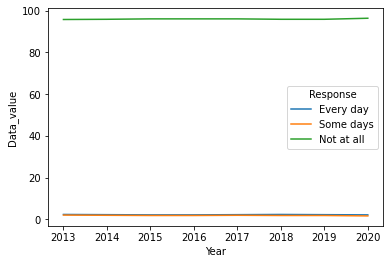

In [33]:
sns.lineplot(data=tb_use_country_chewless,  x='Year', y='Data_value', hue='Response')

In [39]:
tb_use[tb_use['Break_Out']=='Female']

,Year,Locationabbr,Locationdesc,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,...,Confidence_limit_High,Data_value_unit,Data_value_type,Data_Value_Footnote,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
1,2019,KS,Kansas,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Some days,Female,Gender,17,0.40,...,0.62,%,Crude Prevalence,NaN,20,SEX2,CAT2,USENOW3,RESP080,"(38.34774030000045, -98.20078122699965)"
16,2019,FL,Florida,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,Female,Gender,49,0.23,...,0.35,%,Crude Prevalence,NaN,12,SEX2,CAT2,USENOW3,RESP079,"(28.932040377000476, -81.92896053899966)"
34,2019,MN,Minnesota,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,Female,Gender,18,0.20,...,0.32,%,Crude Prevalence,NaN,27,SEX2,CAT2,USENOW3,RESP079,"(46.35564873600049, -94.79420050299967)"
44,2019,NY,New York,Smoker Status,Four Level Smoking Status (variable calculated...,Smoke some days,Female,Gender,253,3.67,...,4.36,%,Crude Prevalence,NaN,36,SEX2,CAT2,_SMOKER3,RESP069,"(42.82700103200045, -75.54397042699964)"
69,2019,AL,Alabama,Current Smoker Status,Adults who are current smokers (variable calcu...,No,Female,Gender,"3,391",81.65,...,83.36,%,Crude Prevalence,NaN,1,SEX2,CAT2,_RFSMOK3,RESP054,"(32.84057112200048, -86.63186076199969)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110902,2020,PR,Puerto Rico,Current Smoker Status,Adults who are current smokers (variable calcu...,No,Female,Gender,"2,745",93.82,...,95.04,%,Crude Prevalence,NaN,72,SEX2,CAT2,_RFSMOK3,RESP054,"(18.220833, -66.590149)"
110927,2020,PR,Puerto Rico,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,Female,Gender,2,NaN,...,NaN,%,Crude Prevalence,Prevalence estimate not available if the unwei...,72,SEX2,CAT2,USENOW3,RESP079,"(18.220833, -66.590149)"
110975,2020,PR,Puerto Rico,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Not at all,Female,Gender,"2,905",99.37,...,99.72,%,Crude Prevalence,NaN,72,SEX2,CAT2,USENOW3,RESP081,"(18.220833, -66.590149)"
110988,2020,PR,Puerto Rico,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Some days,Female,Gender,17,0.57,...,0.90,%,Crude Prevalence,NaN,72,SEX2,CAT2,USENOW3,RESP080,"(18.220833, -66.590149)"


In [37]:
tb_use_us['Break_Out_Category'].unique()

array(['Overall'], dtype=object)

### Age Group vs smoker habit

In [33]:
tb_use.loc[tb_use['Data_value'].isna()]

,Year,Locationabbr,Locationdesc,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,...,Confidence_limit_High,Data_value_unit,Data_value_type,Data_Value_Footnote,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
14,2019,DC,District of Columbia,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,"Other, non-Hispanic",Race/Ethnicity,0,NaN,...,NaN,%,Crude Prevalence,No responses for this data cell,11,RACE06,CAT4,USENOW3,RESP079,"(38.89037138500049, -77.03196112699965)"
24,2019,ME,Maine,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,"Native Hawaiian or other Pacific Islander, non...",Race/Ethnicity,0,NaN,...,NaN,%,Crude Prevalence,No responses for this data cell,23,RACE05,CAT4,USENOW3,RESP079,"(45.254228894000505, -68.98503133599962)"
39,2019,NV,Nevada,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,65+,Age Group,8,NaN,...,NaN,%,Crude Prevalence,Prevalence estimate not available if the unwei...,32,AGE09,CAT3,USENOW3,RESP079,"(39.493240390000494, -117.07184056399967)"
42,2019,NM,New Mexico,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,"Native Hawaiian or other Pacific Islander, non...",Race/Ethnicity,0,NaN,...,NaN,%,Crude Prevalence,No responses for this data cell,35,RACE05,CAT4,USENOW3,RESP079,"(34.52088095200048, -106.24058098499967)"
56,2019,WI,Wisconsin,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Some days,45-54,Age Group,8,NaN,...,NaN,%,Crude Prevalence,Prevalence estimate not available if the unwei...,55,AGE04,CAT3,USENOW3,RESP080,"(44.39319117400049, -89.81637074199966)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111036,2020,PR,Puerto Rico,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Every day,Hispanic,Race/Ethnicity,4,NaN,...,NaN,%,Crude Prevalence,Prevalence estimate not available if the unwei...,72,RACE08,CAT4,USENOW3,RESP079,"(18.220833, -66.590149)"
111041,2020,PR,Puerto Rico,Smokeless Tobacco,"Do you currently use chewing tobacco, snuff, o...",Some days,"$15,000-$24,999",Household Income,10,NaN,...,NaN,%,Crude Prevalence,Prevalence estimate not available if the unwei...,72,INCOME2,CAT6,USENOW3,RESP080,"(18.220833, -66.590149)"
111042,2020,PR,Puerto Rico,Smoker Status,Four Level Smoking Status (variable calculated...,Smoke everyday,"Asian, non-Hispanic",Race/Ethnicity,0,NaN,...,NaN,%,Crude Prevalence,No responses for this data cell,72,RACE04,CAT4,_SMOKER3,RESP068,"(18.220833, -66.590149)"
111045,2020,PR,Puerto Rico,Current Smoker Status,Adults who are current smokers (variable calcu...,No,"Black, non-Hispanic",Race/Ethnicity,2,NaN,...,NaN,%,Crude Prevalence,Prevalence estimate not available if the unwei...,72,RACE02,CAT4,_RFSMOK3,RESP054,"(18.220833, -66.590149)"
